In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

import warnings
warnings.filterwarnings('ignore')

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/'
protein="TNR" #TNR,Agg,WFA,HABP

In [3]:
results = {"filename":[],
          "exp condition":[],
          "mean correlation":[],
          "correlation":[]}
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if "normal_corrs_all" in str(filelist[i]):
            if ("neg" in str(filelist[i]))==False:
                if ("averageprojection" in str(filelist[i]))==False:
                    if filelist[i].endswith(".txt"): 
                        if str(filelist[i][:-12]) not in str(results["filename"]):
                            results["filename"].append(filelist[i])
                            if "maxproj" in str(filelist[i]):
                                results["exp condition"].append(filelist[i].split('/')[-3])
                            else:
                                results["exp condition"].append(filelist[i].split('/')[-2])
                            results["mean correlation"].append(np.loadtxt(filelist[i]).mean())
                            results["correlation"].append(np.loadtxt(filelist[i]))

In [4]:

           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "corrs_rand" in str(filelist[i]):
      #  if "normal_corrs_all" in str(filelist[i]):
       #     if ("posthoc" in str(filelist[i]))==False:
        #        if ("averageprojection" in str(filelist[i]))==False:
                    if filelist[i].endswith(".txt"): 
                        if str(filelist[i][:-12]) not in str(results["filename"]):
                            results["filename"].append(filelist[i])
                            if "maxproj" in str(filelist[i]):
                                results["exp condition"].append(filelist[i].split('/')[-3])
                            else:
                                results["exp condition"].append(filelist[i].split('/')[-2])
                            results["mean correlation"].append(np.loadtxt(filelist[i]).mean())
                            results["correlation"].append(np.loadtxt(filelist[i]))

## Plots

In [5]:
newdf=pd.DataFrame(results)

In [6]:
newdf['Protein']='None'
newdf.loc[(newdf['filename'].str.contains('nt'))&(newdf['filename'].str.contains('12')), 'Protein'] = 'Int1b, all TNR Blk+12, stripped'
newdf.loc[(newdf['filename'].str.contains('nt'))&(newdf['filename'].str.contains('surface')), 'Protein'] = 'Int1b Blk/TNR Blk, +0, surface'
newdf.loc[newdf['filename'].str.contains('tgn'), 'Protein'] = 'TGN38/ TNR Blk, +12'
newdf.loc[newdf['filename'].str.contains('rab11'), 'Protein'] = 'Rab11a/ TNR Blk, +12'
newdf.loc[newdf['filename'].str.contains('cav'), 'Protein'] = 'Cav1/ TNR Blk'
newdf.loc[newdf['filename'].str.contains('negctrl'), 'Protein'] = 'Neg ctrl vAchT'
newdf.loc[newdf['filename'].str.contains('positivecontrol'), 'Protein'] = 'Pos ctrl 2 secondaries'
newdf.loc[newdf['filename'].str.contains('rab7'), 'Protein'] = 'Rab7/ TNR Blk, +12'
newdf.loc[newdf['filename'].str.contains('rab5'), 'Protein'] = 'Rab5/ TNR Blk, +12'
newdf.loc[newdf['filename'].str.contains('lamp'), 'Protein'] = 'lamp1/ TNR Blk, +12'
newdf.loc[(newdf['filename'].str.contains('calreticulin'))&(newdf['filename'].str.contains('maxprojection')),'Protein'] = 'Calreticulin/ TNR Blk, +12, max proj'
newdf.loc[(newdf['filename'].str.contains('calreticulin'))&(newdf['filename'].str.contains('averageprojection')),'Protein'] = 'Calreticulin/ TNR Blk, +12, mean proj'
newdf.loc[(newdf['filename'].str.contains('calnexin'))&(newdf['filename'].str.contains('maxprojection')),'Protein'] = 'Calnexin/ TNR Blk, +12, max proj'
newdf.loc[(newdf['filename'].str.contains('calnexin'))&(newdf['filename'].str.contains('averageprojection')),'Protein'] = 'Calnexin/ TNR Blk, +12, mean proj'




<Figure size 432x288 with 0 Axes>

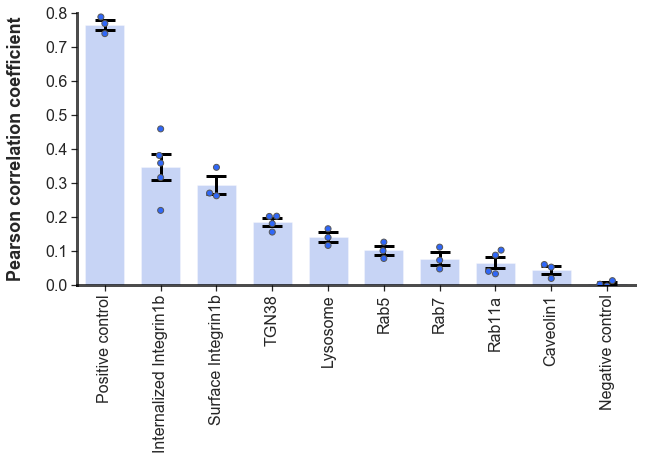

In [7]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")

order=['Pos ctrl 2 secondaries','Int1b, all TNR Blk+12, stripped','Int1b Blk/TNR Blk, +0, surface',
       'TGN38/ TNR Blk, +12','lamp1/ TNR Blk, +12','Rab5/ TNR Blk, +12',
      'Rab7/ TNR Blk, +12','Rab11a/ TNR Blk, +12','Cav1/ TNR Blk','Neg ctrl vAchT']
names=['Positive control','Internalized Integrin1b','Surface Integrin1b','TGN38','Lysosome','Rab5','Rab7',
      'Rab11a','Caveolin1','Negative control']

var="mean correlation"
fig=plt.figure(figsize=(10,5))
#order=['2hrs','4hrs','12hrs','No Blocking']
#palette ={"No Blocking":"gray","2hrs":"magenta","4hrs":"magenta","12hrs":"magenta"}

g=sns.swarmplot(x="Protein",y=var,
                data=newdf,size=6,color="#2F67F8",linewidth=1,order=order)

g=sns.barplot(x="Protein",y=var,
                data=newdf,alpha=0.3,ci=None,color="#2F67F8",order=order)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
change_width(g, .7)

plt.errorbar(x=np.arange(0,len(order)),
             y=[newdf[newdf["Protein"]==protein][var].mean() for protein in order],
             yerr=[newdf[newdf["Protein"]==protein][var].sem() for protein in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3)


#scale_y=1/100
#ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
#g.yaxis.set_major_formatter(ticks_y)
g.set_ylabel('Pearson correlation coefficient',size=18,weight ='bold',labelpad=20)
g.set_xlabel('',size=14,weight ='bold',labelpad=20)
plt.xticks(g.get_xticks(),names,size=16,rotation=90)
plt.yticks(g.get_yticks(),size=16)
g.grid(False)
plt.ylim([0,0.8])

sns.despine(ax=g,right=True,top=True)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(3)
  g.spines[axis].set_color('black')
  g.spines[axis].set_alpha(.7)

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'organellecoloc.svg', bbox_inches='tight', format='svg')


#plt.ylim([-0.1,0.7])

In [8]:
len(names)

10

In [9]:
for item in order:
    print(item)

Pos ctrl 2 secondaries
Int1b, all TNR Blk+12, stripped
Int1b Blk/TNR Blk, +0, surface
TGN38/ TNR Blk, +12
lamp1/ TNR Blk, +12
Rab5/ TNR Blk, +12
Rab7/ TNR Blk, +12
Rab11a/ TNR Blk, +12
Cav1/ TNR Blk
Neg ctrl vAchT


In [10]:
for protein in newdf["Protein"].unique():
    dfprot=newdf[newdf["Protein"]==protein]
    
    plt.figure()
    plt.hist(np.mean(dfprot["correlation"]))
    plt.title(protein)

TypeError: operands could not be broadcast together with shapes (698,) (471,) 

<Figure size 432x288 with 0 Axes>

In [11]:
newdf["exp condition"].unique()

array(['20190612_tnr550_blkplus12_tgn38acy2_analyse',
       '20190523_tnr550_intfitc_blockedplus12_stripped',
       '20190605_tnr647blockplus12_int1fitc_contactincy3',
       '20190515_TNR550_Int1beta_stripped_plus12hr',
       '20190515_TNR550_Int1beta_stripped_plus12hr_cs34',
       '20190612_tnr550_blkplus12_rab11acy2',
       '20190612_tnr550_blkplus2_cav1cy2',
       '20190612_tnr647_blkplus12_tgn38acy2',
       '20190515_tnr550blocked_int1fitcblocked_plus0h_onlysurface_analyse',
       '20190526_tnr550blocked_int1fitcblocked_plus0h_surfaceimaging',
       '20190612_tnr647_blkplus12_intfitc_ctccy3_stripped',
       '20190611__tnr550blocked_int1fitcblocked_vglut635p_ctc1AMCA_plus0h_onlysurface_analyse',
       '20190522_tnr550_blkplus2_cav1cy2_goodparams',
       '20190522_tnr550_blkplus20min_cav1cy2_goodparams',
       '20190505_tnr550_blkplus12_postliveexp_rab11a_goodparams',
       '20190612_tnr647_blkplus12_rab11acy2',
       '20190712_tnr550_blkplus12_lampcy2_analyse',
     

In [12]:
np.sum(dfprot["correlation"][0]>0.7)

20

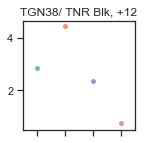

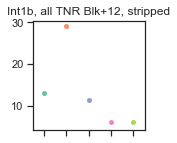

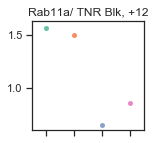

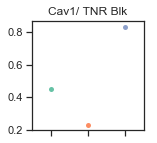

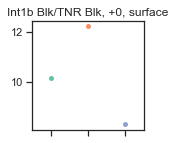

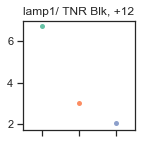

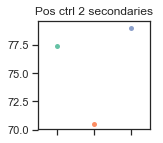

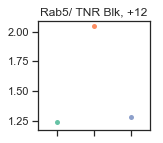

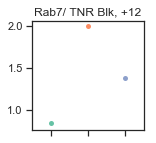

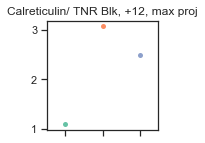

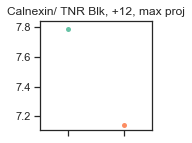

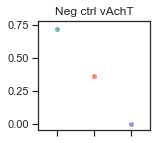

In [13]:
results_allprot={"Protein":[],"expnumber":[],"perc_over":[]}
for protein in newdf["Protein"].unique():
    dfprot=newdf[newdf["Protein"]==protein]
    dfprot=dfprot.reset_index()
    percentages=[]
    expi=[]
    count=1
    for exp in dfprot["exp condition"].unique():
        dfexp=dfprot[dfprot["exp condition"]==exp]
        a=np.sum(dfexp["correlation"].values[0]>0.7)/len(dfexp["correlation"].values[0])*100
        percentages.append(a)
        expi.append(exp)
        results_allprot["Protein"].append(protein)
        results_allprot["expnumber"].append(count)
        results_allprot["perc_over"].append(a)
        count+=1
    plt.figure(figsize=(2,2))
    g=sns.swarmplot(x=expi,y=percentages)
    plt.title(protein)
    plt.xticks(g.get_xticks(),'')
    

In [245]:
df_all=pd.DataFrame(results_allprot)

In [248]:
df_all.to_csv("/Volumes/Macintosh HD/Users/taldankovich/Downloads/allvals.csv'",sep=';')